### **Axial LOB**

In [56]:
# load packages

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path
from tqdm import tqdm 
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch
from torch.utils import data
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
 


Using device: cpu


### **Data**
The dataset used is the FI-2010 dataset.

As in the original paper I used the first 7 days to train and to validate, and the rest 3 days to do the the testing.

In [57]:
# please change the data_path to your local path and unzip the file

dec_data = np.loadtxt('BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_ZScore_CF_7.txt')
dec_train = dec_data[:, :int(dec_data.shape[1] * 0.8)]
dec_val = dec_data[:, int(dec_data.shape[1] * 0.8):]

dec_test1 = np.loadtxt('BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing/Test_Dst_NoAuction_ZScore_CF_7.txt')
dec_test2 = np.loadtxt('BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing/Test_Dst_NoAuction_ZScore_CF_8.txt')
dec_test3 = np.loadtxt('BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing/Test_Dst_NoAuction_ZScore_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

W = 40                     #number of features
dim = 40                     #number of LOB states

horizon = 2        #if h = 5 than k = 10, h = 2 then k=50
T = 5

y_train = dec_train[-horizon, :].flatten()

y_val = dec_val[-horizon, :].flatten()
y_test = dec_test[-horizon, :].flatten()

y_train = y_train[dim-1:] - 1
y_val = y_val[dim-1:] - 1
y_test = y_test[dim-1:] - 1 

dec_train = dec_train[:40, :].T
dec_val = dec_val[:40, :].T
dec_test = dec_test[:40, :].T

print("Training data shape:", dec_train.shape)
print("Validation data shape:", dec_val.shape)
print("Testing data shape:", dec_test.shape)


Training data shape: (203800, 40)
Validation data shape: (50950, 40)
Testing data shape: (139587, 40)


In [58]:
class Dataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, x, y, num_classes, dim):
        """Initialization""" 
        self.num_classes = num_classes
        self.dim = dim
        self.x = x   
        self.y = y

        self.length = x.shape[0] - T - self.dim + 1
        print(self.length)

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.y = torch.from_numpy(y)

    def __len__(self):
        """Denotes the total number of samples"""
        return self.length

    def __getitem__(self, i):
        input = self.x[i:i+self.dim, :]
        input = input.permute(1, 0, 2)
        
        return input, self.y[i]

In [59]:
#Hyperparameters

batch_size = 64
epochs = 3 
c_final = 4              #channel output size of the second conv
n_heads = 4
c_in_axial = 32          #channel output size of the first conv
c_out_axial = 32
pool_kernel = (1, 4)
pool_stride = (1, 4)

num_classes = 3

dataset_val = Dataset(dec_val, y_val, num_classes, dim)
dataset_test = Dataset(dec_test, y_test, num_classes, dim)
dataset_train = Dataset(dec_train, y_train, num_classes, dim)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

inputs, labels = next(iter(train_loader))
print("Input batch shape:", inputs.shape)
print("Label batch shape:", labels.shape)

50906
139543
203756
Input batch shape: torch.Size([64, 1, 40, 40])
Label batch shape: torch.Size([64])


### **Model Architecture**


In [60]:
import math

def _conv1d1x1(in_channels, out_channels):
  return nn.Sequential(nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
                         nn.BatchNorm1d(out_channels))

#class taken from https://github.com/jeya-maria-jose/Medical-Transformer/blob/main/lib/models/axialnet.py
class GatedAxialAttention(nn.Module):
    def __init__(self, in_channels, out_channels, heads, dim, flag):
        assert (in_channels % heads == 0) and (out_channels % heads == 0)
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.dim_head_v = out_channels // heads
        self.flag = flag                #if flag then we do the attention along width
        self.dim = dim
        self.dim_head_qk = self.dim_head_v // 2
        self.qkv_channels = self.dim_head_v + self.dim_head_qk * 2

        # Multi-head self attention
        self.to_qkv = _conv1d1x1(in_channels, self.heads * self.qkv_channels)
        self.bn_qkv = nn.BatchNorm1d(self.heads * self.qkv_channels)
        self.bn_similarity = nn.BatchNorm2d(heads * 3)
        self.bn_output = nn.BatchNorm1d(self.heads * self.qkv_channels)

        # Gating mechanism
        self.f_qr = nn.Parameter(torch.tensor(0.3),  requires_grad=False) 
        self.f_kr = nn.Parameter(torch.tensor(0.3),  requires_grad=False)
        self.f_sve = nn.Parameter(torch.tensor(0.3),  requires_grad=False)
        self.f_sv = nn.Parameter(torch.tensor(0.5),  requires_grad=False)

        # Position embedding
        self.relative = nn.Parameter(torch.randn(self.dim_head_v * 2, dim * 2 - 1), requires_grad=True)
        query_index = torch.arange(dim).unsqueeze(0)
        key_index = torch.arange(dim).unsqueeze(1)
        relative_index = key_index - query_index + dim - 1
        self.register_buffer('flatten_index', relative_index.view(-1))

        self.reset_parameters()
        # self.print_para()

    def forward(self, x):
        
        if self.flag:
            x = x.permute(0, 2, 1, 3)
        else:
            x = x.permute(0, 3, 1, 2)  # N, W, C, H
        N, W, C, H = x.shape
        x = x.contiguous().view(N * W, C, H)

        # Transformations
        x = self.to_qkv(x)
        
        qkv = self.bn_qkv(x)
        q, k, v = torch.split(qkv.reshape(N * W, self.heads, self.dim_head_v * 2, H), [self.dim_head_v // 2, self.dim_head_v // 2, self.dim_head_v], dim=2)

        # Calculate position embedding
        all_embeddings = torch.index_select(self.relative, 1, self.flatten_index).view(self.dim_head_v * 2, self.dim, self.dim)
        q_embedding, k_embedding, v_embedding = torch.split(all_embeddings, [self.dim_head_qk, self.dim_head_qk, self.dim_head_v], dim=0)
        qr = torch.einsum('bgci,cij->bgij', q, q_embedding)
        kr = torch.einsum('bgci,cij->bgij', k, k_embedding).transpose(2, 3)
        qk = torch.einsum('bgci, bgcj->bgij', q, k)


        # multiply by factors
        qr = torch.mul(qr, self.f_qr)
        kr = torch.mul(kr, self.f_kr)

        stacked_similarity = torch.cat([qk, qr, kr], dim=1)
        stacked_similarity = self.bn_similarity(stacked_similarity).view(N * W, 3, self.heads, H, H).sum(dim=1)
        #stacked_similarity = self.bn_qr(qr) + self.bn_kr(kr) + self.bn_qk(qk)
        # (N, heads, H, H, W)
        similarity = torch.softmax(stacked_similarity, dim=3)
        sv = torch.einsum('bgij,bgcj->bgci', similarity, v)
        sve = torch.einsum('bgij,cij->bgci', similarity, v_embedding)

        # multiply by factors
        sv = torch.mul(sv, self.f_sv)
        sve = torch.mul(sve, self.f_sve)

        stacked_output = torch.cat([sv, sve], dim=-1).view(N * W, self.out_channels * 2, H)
        output = self.bn_output(stacked_output).view(N, W, self.out_channels, 2, H).sum(dim=-2)

        if self.flag:
            output = output.permute(0, 2, 1, 3)
        else:
            output = output.permute(0, 2, 3, 1)

        return output


    def reset_parameters(self):
        nn.init.normal_(self.relative, 0., math.sqrt(1. / self.dim_head_v))


class AxialLOB(nn.Module):
    def __init__(self, W, H, c_in, c_out, c_final, n_heads, pool_kernel, pool_stride):
        super().__init__()

        """
        Args:
          W and H:  the width and height of the input tensors
          c_in, c_out, and c_final:  the number of channels for the input, intermediate, and final convolutional layers
          n_heads:  the number of heads for the multi-head attention mechanism used in the GatedAxialAttention layers.
          pool_kernel and pool_stride:  the kernel size and stride of the final average pooling layer.
        """

        #channel output of the CNN_in is the channel input for the axial layer
        self.c_in = c_in
        self.c_out = c_out
        self.c_final = c_final

        self.CNN_in = nn.Conv2d(in_channels=1, out_channels=c_in, kernel_size=1)
        self.CNN_out = nn.Conv2d(in_channels=c_out, out_channels=c_final, kernel_size=1)
        self.CNN_res2 = nn.Conv2d(in_channels=c_out, out_channels=c_final, kernel_size=1)
        self.CNN_res1 = nn.Conv2d(in_channels=1, out_channels=c_out, kernel_size=1)

        self.norm = nn.BatchNorm2d(c_in)
        self.res_norm2 = nn.BatchNorm2d(c_final)
        self.res_norm1 = nn.BatchNorm2d(c_out)
        self.norm2 = nn.BatchNorm2d(c_final)
        self.axial_height_1 = GatedAxialAttention(c_out, c_out, n_heads, H, flag=False)
        self.axial_width_1 = GatedAxialAttention(c_out, c_out, n_heads, W, flag=True)
        self.axial_height_2 = GatedAxialAttention(c_out, c_out, n_heads, H, flag=False)
        self.axial_width_2 = GatedAxialAttention(c_out, c_out, n_heads, W, flag=True)

        self.activation = nn.ReLU()
        self.linear = nn.Linear(1600, 3)
        self.pooling = nn.AvgPool2d(kernel_size=pool_kernel, stride=pool_stride)

    def forward(self, x):
        
        #up branch
        #first convolution before the attention
        y = self.CNN_in(x)
        y = self.norm(y)
        y = self.activation(y)

        #attention mechanism through gated multi head axial layer
        y = self.axial_width_1(y)
        y = self.axial_height_1(y)

        #lower branch
        x = self.CNN_res1(x)
        x = self.res_norm1(x)
        x = self.activation(x)

        #first residual
        y = y + x
        z = y.detach().clone()

        #second axial layer
        y = self.axial_width_2(y)
        y = self.axial_height_2(y)
        
        #second convolution
        y = self.CNN_out(y)
        y = self.res_norm2(y)
        y = self.activation(y)

        #lower branch
        z = self.CNN_res2(z)
        z = self.norm2(z)
        z = self.activation(z)

        #second res connection
        y = y + z

        #final part
        y = self.pooling(y)
        y = torch.flatten(y, 1)
        y = self.linear(y)
        forecast_y = torch.softmax(y, dim=1)
        return forecast_y

### **Model Training**

In [61]:
axial_lob_model = AxialLOB(W, dim, c_in_axial, c_out_axial, c_final, n_heads, pool_kernel, pool_stride)
axial_lob_model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(axial_lob_model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.00001)

def batch_gd(model, criterion, optimizer, scheduler, epochs, model_name, force_save=False):
    if not force_save:
        save_path = Path(model_name)
        if save_path.exists():
            raise ValueError(
                f"{model_name} exists already. Please use a different path/name "
                    + "or set force_save=True to override the current model"
            )
            

    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    best_test_loss = np.inf
    best_test_epoch = 0
    start_time = datetime.now()
    for it in tqdm(range(epochs)):

        if (it == 4 and isinstance(model, AxialLOB)):
          print("Turning on additional grads for AxialLOB...")
          model.axial_height_1.f_qr.requires_grad = True
          model.axial_height_1.f_kr.requires_grad = True
          model.axial_height_1.f_sve.requires_grad = True
          model.axial_height_1.f_sv.requires_grad = True

          model.axial_width_1.f_qr.requires_grad = True
          model.axial_width_1.f_kr.requires_grad = True
          model.axial_width_1.f_sve.requires_grad = True
          model.axial_width_1.f_sv.requires_grad = True

          model.axial_height_2.f_qr.requires_grad = True
          model.axial_height_2.f_kr.requires_grad = True
          model.axial_height_2.f_sve.requires_grad = True
          model.axial_height_2.f_sv.requires_grad = True

          model.axial_width_2.f_qr.requires_grad = True
          model.axial_width_2.f_kr.requires_grad = True
          model.axial_width_2.f_sve.requires_grad = True
          model.axial_width_2.f_sv.requires_grad = True

        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:

            # move data to GPU
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
           
            outputs = model(inputs)
            
            loss = criterion(outputs, targets)
            
            # Backward and optimize
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            
        # Get train loss and test loss
        train_loss = np.mean(train_loss)
    
        model.eval()
        test_loss = []
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)      
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        scheduler.step()
        
        #We save the best model
        if test_loss < best_test_loss:
            torch.save(model, model_name)
            best_test_loss = test_loss
            best_test_epoch = it
            print(f'model saved at {model_name}')

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {test_loss:.4f}, Duration: {dt}, Best Val Epoch: {best_test_epoch}')
    
    time_training = datetime.now() - start_time
    print(f"Full time to train: {time_training}. Average time per epoch: {time_training / epochs}")
    return train_losses, test_losses

In [62]:
# If the model is already in all_models, you can skip this block
# unless you want to train the AxialLOB model further
print("------- List Hyper Parameters -------")
print("epochs   ->   " + str(epochs))
print("horizon    ->     " + str(T*10))
print("batch size   ->    " + str(batch_size))
print("Optimizer   ->    " + str(optimizer))

# Save to the all_models directory
# If it doesn't exist, make it
save_dir = Path("all_models")
save_dir.mkdir(parents=True, exist_ok=True)
model_name = "all_models/AxialLOB.pt"
force_save = False

# If you want to start completely from scratch,
# comment out the following code and set force_save = True above
model_path = Path(model_name)
if model_path.exists():
    force_save = True
    print("Loading existing axial_lob_model...")
    axial_lob_model = torch.load(model_name).to(device)
    print("Model Loaded")

# NOTE: Set the following lines to True to train the model. Set it to False to skip
if False:
    train_losses, val_losses = batch_gd(axial_lob_model, criterion, optimizer, scheduler, epochs, model_name, force_save=force_save)

    plt.figure(figsize=(15,6))
    plt.plot(train_losses, label='train loss')
    plt.plot(val_losses, label='validation loss')
    plt.legend()

------- List Hyper Parameters -------
epochs   ->   3
horizon    ->     50
batch size   ->    64
Optimizer   ->    SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    initial_lr: 0.01
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
Loading existing axial_lob_model...


C:\Users\monam\AppData\Local\Temp\ipykernel_22432\865549477.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  axial_lob_model = torch.load(model_name).to(device)


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

### **Model Testing**

In [63]:
def test_model(model, criterion):
    n_correct = 0.
    n_total = 0.
    all_targets = []
    all_predictions = []

    test_loss = []
    t0 = datetime.now()
    for inputs, targets in test_loader:
        # Move to GPU
        inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Get prediction
        # torch.max returns both max and argmax
        _, predictions = torch.max(outputs, 1)
        
        # update counts
        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

        all_targets.append(targets.cpu().numpy())
        all_predictions.append(predictions.cpu().numpy())
        test_loss.append(loss.item())
    dt = datetime.now() - t0
    test_loss = np.mean(test_loss)

    test_acc = n_correct / n_total
    print(f"Test acc: {test_acc:.4f}. Test Loss: {test_loss:.4f}. Time on test: {dt}")
    
    all_targets = np.concatenate(all_targets)    
    all_predictions = np.concatenate(all_predictions)
    return all_targets, all_predictions

In [64]:
axial_lob_model = torch.load(model_name).to(device)
all_targets, all_predictions = test_model(axial_lob_model, criterion)
print(classification_report(all_targets, all_predictions, digits=4))

c = confusion_matrix(all_targets, all_predictions, normalize="true")
disp = ConfusionMatrixDisplay(c)
disp.plot()
plt.show()

C:\Users\monam\AppData\Local\Temp\ipykernel_22432\158963912.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  axial_lob_model = torch.load(model_name).to(device)


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

# Model Comparisons
We will now test additional models to compare their performance against AxialLOB.

In [65]:
models_to_test: dict[str, nn.Module] = {}

In [66]:
class CNN(nn.Module):
    def __init__(self, W, num_classes):
        super().__init__()
        self.conv = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(16, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

models_to_test["CNN"] = CNN(W, num_classes).to(device)

In [67]:
class DeepLOB(nn.Module):
    def __init__(self, W, hidden_size, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.lstm = nn.LSTM(W * 128, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(
            nn.Linear(2 * hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.relu(self.bn3(self.conv3(x)))
        batch_size, channels, height, width = x.size()
        x = x.view(batch_size, height, -1)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        return self.fc(x)

hidden_size = 64
models_to_test["DeepLOB"] = DeepLOB(W, hidden_size, num_classes).to(device)

In [68]:
class B_TABL(nn.Module):
    def __init__(self, W, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(W * W, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

class C_TABL(nn.Module):
    def __init__(self, W, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(W * W, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

models_to_test["B_TABL"] = B_TABL(W, num_classes).to(device)
models_to_test["C_TABL"] = C_TABL(W, num_classes).to(device)

In [69]:
class DeepLOBSeq2Seq(nn.Module):
    def __init__(self, W, hidden_size, num_classes):
        super().__init__()
        self.encoder = nn.LSTM(W, hidden_size, batch_first=True, bidirectional=True)
        self.decoder = nn.LSTM(W, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(
            nn.Linear(2 * hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        batch_size, _, height, _ = x.size()
        x = x.view(batch_size, height, -1)  # Flatten spatial dimensions
        _, (hidden, _) = self.encoder(x)  # Encoder outputs
        x, _ = self.decoder(x)  # Decoder processes input
        x = x[:, -1, :]  # Use last time-step
        return self.fc(x)

hidden_size = 64
models_to_test["DeepLOBSeq2Seq"] = DeepLOBSeq2Seq(W, hidden_size, num_classes).to(device)

In [70]:
class DeepLOBAttention(nn.Module):
    def __init__(self, W, hidden_size, num_classes):
        super().__init__()
        self.encoder = nn.LSTM(W, hidden_size, batch_first=True, bidirectional=True)
        self.attention = nn.Sequential(
            nn.Linear(2 * hidden_size, 128),
            nn.Tanh(),
            nn.Linear(128, 1),
            nn.Softmax(dim=1)
        )
        self.fc = nn.Sequential(
            nn.Linear(2 * hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        batch_size, _, height, _ = x.size()
        x = x.view(batch_size, height, -1)  # Flatten spatial dimensions
        x, _ = self.encoder(x)  # Encoder outputs
        attention_weights = self.attention(x)  # Compute attention weights
        x = torch.sum(attention_weights * x, dim=1)  # Apply attention
        return self.fc(x)

hidden_size = 64
models_to_test["DeepLOBAttention"] = DeepLOBAttention(W, hidden_size, num_classes).to(device)

Test acc: 0.4729. Test Loss: 1.0563. Time on test: 0:01:22.856168


C:\Users\monam\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\monam\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\monam\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000     38447
           1     0.4729    1.0000    0.6422     65996
           2     0.0000    0.0000    0.0000     35100

    accuracy                         0.4729    139543
   macro avg     0.1576    0.3333    0.2141    139543
weighted avg     0.2237    0.4729    0.3037    139543



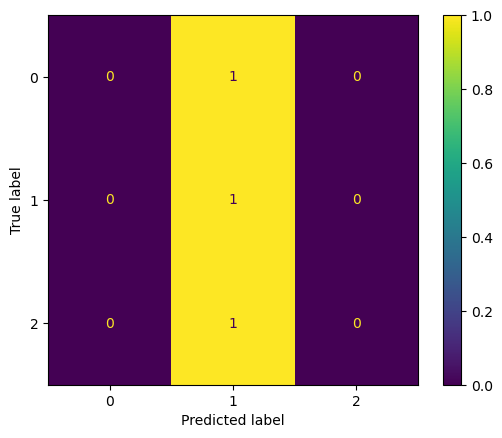

KeyboardInterrupt: 

In [71]:
class FakeScheduler():
    "Class so we can call batch_gd with no scheduler"
    def step(self):
        pass

def evaluate_all(models: dict[str, nn.Module], epochs_per_model: int, train_model: bool = False):
    """
    Trains each model in models on the dataset
    Modifies models in place by replacing the untrained models with the trained ones
    """
    save_dir = Path("all_models")
    save_dir.mkdir(parents=True, exist_ok=True)

    for model_name, model in models.items():

        criterion = nn.CrossEntropyLoss()

        if train_model:
            # Train the model and save it
            print(f"Training {model_name}...")
            model.to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            scheduler = FakeScheduler()

            save_path = save_dir / f"{model_name}.pt"
            batch_gd(model, criterion, optimizer, scheduler, epochs_per_model, str(save_path), force_save=True)

        # Evaluate the model
        # Load the best saved model
        all_targets, all_predictions = test_model(model, criterion)

        print(classification_report(all_targets, all_predictions, digits=4))

        c = confusion_matrix(all_targets, all_predictions, normalize="true")
        disp = ConfusionMatrixDisplay(c)
        disp.plot()
        plt.show()

        # Replace old model with new model
        models[model_name] = model
    
evaluate_all(models_to_test, 5)

# Run a Market Simulation

In [55]:
class BuySellDataset(data.Dataset):
    """
    Dataset to handle buying and selling simulation
    """
    def __init__(self, x, num_classes, dim, rescale_prices: bool = True):
        """Initialization""" 
        self.num_classes = num_classes
        self.dim = dim
        self.x = x
        self.prices = self.compute_mid_prices(x, rescale_prices)

        self.length = x.shape[0] - T - self.dim + 1

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.prices = torch.from_numpy(self.prices)

    def compute_mid_prices(self, x, rescale_prices: bool = True):
        """
        Compute the mid-price as the average of ask and bid prices.
        Assuming ask and bid prices are alternating in the columns.
        """
        mid_prices = []
        for i in range(x.shape[0]):
            ask_prices = x[i, 0]  # Assuming best ask is at column 1
            bid_prices = x[i, 20]  # Assuming best bid is at column 21
            mid_price = (ask_prices + bid_prices) / 2  # Calculate mid-price
            mid_prices.append(mid_price)
        mid_prices = np.array(mid_prices)
        if rescale_prices:
            mid_prices = mid_prices - np.min(mid_prices) + 0.5 # ensure price >=0.5 so no negative or 0 prices
        return mid_prices

    def __len__(self):
        """Denotes the total number of samples"""
        return self.length

    def __getitem__(self, i):
        input = self.x[i:i+self.dim, :]
        input = input.permute(1, 0, 2)
        
        return input, self.prices[i]

buy_sell_dataset_test = BuySellDataset(dec_test, num_classes, dim, rescale_prices=True)
buy_sell_test_loader = torch.utils.data.DataLoader(dataset=buy_sell_dataset_test, batch_size=batch_size, shuffle=False)


# Trading Strategy Simulation
def simulate_trading_debug(preds, prices, initial_cash=10000, transaction_cost=0.001):
    cash = initial_cash
    stock = 0
    print(f"Initial cash: {cash}, transaction cost: {transaction_cost}")

    for i, (pred, price) in enumerate(zip(preds, prices)):
        if pred == 2:  # Buy signal
            num_shares = cash / (price * (1 + transaction_cost))
            cash -= num_shares * price * (1 + transaction_cost)
            stock += num_shares
            print(f"BUY at step {i}: Bought {num_shares:.2f} shares at {price:.2f}, Cash: {cash:.2f}, Stock: {stock:.2f}")
        elif pred == 0:  # Sell signal
            cash += stock * price * (1 - transaction_cost)
            print(f"SELL at step {i}: Sold {stock:.2f} shares at {price:.2f}, Cash: {cash:.2f}")
            stock = 0
        # Hold signal does nothing

    portfolio_value = cash + stock * prices[-1]
    print(f"Final Portfolio Value: {portfolio_value:.2f}, Remaining Cash: {cash:.2f}, Remaining Stock: {stock:.2f}")
    return portfolio_value

# Evaluation with Debugging
def evaluate_strategy_debug(model: nn.Module):
    """
    Given a trained model, test how well it does at trading
    """
    model.eval()
    all_preds = []
    prices_test = []
    with torch.no_grad():
        for inputs, prices in buy_sell_test_loader:
            inputs = inputs.to(device, dtype=torch.float)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu().numpy())
            prices_test.append(prices.cpu().numpy())


    preds = np.concatenate(all_preds)
    prices_test = np.concatenate(prices_test)
    if len(preds) >= 10:
        print(f"Predictions: {preds[:10]} ... {preds[-10:]} (first 10 and last 10 predictions)")
    return simulate_trading_debug(preds, prices_test)

# Evaluate the model
evaluate_strategy_debug(axial_lob_model)


Predictions: [2 0 0 0 0 0 0 0 0 2] ... [1 1 1 1 1 1 1 1 1 1] (first 10 and last 10 predictions)
Initial cash: 10000, transaction cost: 0.001
BUY at step 0: Bought 5197.97 shares at 1.92, Cash: -0.00, Stock: 5197.97
SELL at step 1: Sold 5197.97 shares at 1.93, Cash: 10016.30
SELL at step 2: Sold 0.00 shares at 1.92, Cash: 10016.30
SELL at step 3: Sold 0.00 shares at 1.93, Cash: 10016.30
SELL at step 4: Sold 0.00 shares at 1.92, Cash: 10016.30
SELL at step 5: Sold 0.00 shares at 1.93, Cash: 10016.30
SELL at step 6: Sold 0.00 shares at 1.92, Cash: 10016.30
SELL at step 7: Sold 0.00 shares at 1.93, Cash: 10016.30
SELL at step 8: Sold 0.00 shares at 1.92, Cash: 10016.30
BUY at step 9: Bought 5199.69 shares at 1.92, Cash: 0.00, Stock: 5199.69
BUY at step 10: Bought 0.00 shares at 1.92, Cash: 0.00, Stock: 5199.69
SELL at step 11: Sold 5199.69 shares at 1.92, Cash: 9985.92
SELL at step 12: Sold 0.00 shares at 1.92, Cash: 9985.92
SELL at step 13: Sold 0.00 shares at 1.92, Cash: 9985.92
BUY at s

0.0040897006916119985

# Test on APPL Data

In [43]:
#DeepLOB attention
# Reuse existing components from earlier blocks without redefinition.

# Evaluation with P&L calculation for DeepLOB Attention
def evaluate_strategy_with_pnl(model, data_np, horizons, batch_size=32):
    """
    Evaluate DeepLOB Attention model with P&L calculation.
    Reuses `train_model`, `evaluate_model`, and `simulate_trading_debug` from earlier blocks.
    """
    results = []
    model.to(device)

    for horizon in horizons:
        print(f"\nEvaluating for Prediction Horizon: {horizon}")

        # Use existing sequence creation logic
        X, y, prices = create_sequences(data_np, dim, horizon)
        train_size = int(0.8 * len(X))
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]
        prices_test = prices[train_size:]

        # Reuse DataLoader setup
        train_loader = torch.utils.data.DataLoader(
            StockDataset(X_train, y_train), batch_size=batch_size, shuffle=True
        )
        test_loader = torch.utils.data.DataLoader(
            StockDataset(X_test, y_test), batch_size=batch_size, shuffle=False
        )

        # Reuse training and evaluation logic
        train_model(model, train_loader, num_epochs=10)  # Assumes `train_model` is defined
        preds = evaluate_model(model, test_loader)  # Assumes `evaluate_model` is defined

        # Reuse trading simulation logic
        portfolio_value = simulate_trading_debug(preds, prices_test)  # Assumes `simulate_trading_debug` is defined
        results.append({"Horizon": horizon, "Portfolio Value": portfolio_value})

    return pd.DataFrame(results)

# Prepare stock data (reuse fetch_stock_data)
ticker = "AAPL"
start_date = "2020-01-01"
end_date = "2023-01-01"
data = fetch_stock_data(ticker, start_date, end_date)  # Assumes `fetch_stock_data` is defined
data_np = data[['Open', 'High', 'Low', 'Close', 'Volume', 'Returns', 'MA_10', 'EMA_10', 'RSI', 'MACD', 'Signal_Line', 'BB_Upper', 'BB_Lower']].to_numpy()
W = data_np.shape[1]  # Number of features

# Use the existing DeepLOBAttention definition
# Assume `DeepLOBAttention` was defined earlier and does not need redefining
deep_lob_model = DeepLOBAttention(W, hidden_size, num_classes).to(device)

# Evaluate the DeepLOB Attention model
deep_lob_results = evaluate_strategy_with_pnl(deep_lob_model, data_np, horizons, batch_size)
print(f"Results for DeepLOB_Attention:\n{deep_lob_results}")



Evaluating for Prediction Horizon: 5
Epoch 1, Loss: 1.0090
Epoch 2, Loss: 0.8933
Epoch 3, Loss: 0.8827
Epoch 4, Loss: 0.8704
Epoch 5, Loss: 0.8746
Epoch 6, Loss: 0.8781
Epoch 7, Loss: 0.8734
Epoch 8, Loss: 0.8682
Epoch 9, Loss: 0.8715
Epoch 10, Loss: 0.8688

Evaluating for Prediction Horizon: 10
Epoch 1, Loss: 0.8821
Epoch 2, Loss: 0.8689
Epoch 3, Loss: 0.8621
Epoch 4, Loss: 0.8688
Epoch 5, Loss: 0.8653
Epoch 6, Loss: 0.8688
Epoch 7, Loss: 0.8663
Epoch 8, Loss: 0.8757
Epoch 9, Loss: 0.8752
Epoch 10, Loss: 0.8681

Evaluating for Prediction Horizon: 20
Epoch 1, Loss: 0.8678
Epoch 2, Loss: 0.8735
Epoch 3, Loss: 0.8807
Epoch 4, Loss: 0.8660
Epoch 5, Loss: 0.8797
Epoch 6, Loss: 0.8635
Epoch 7, Loss: 0.8722
Epoch 8, Loss: 0.8711
Epoch 9, Loss: 0.8627
Epoch 10, Loss: 0.8666

Evaluating for Prediction Horizon: 30
Epoch 1, Loss: 0.8728
Epoch 2, Loss: 0.8563
Epoch 3, Loss: 0.8673
Epoch 4, Loss: 0.8785
Epoch 5, Loss: 0.8548
Epoch 6, Loss: 0.8757
Epoch 7, Loss: 0.8723
Epoch 8, Loss: 0.8814
Epoch 

In [29]:
# AxialLOB Evaluation 
# Reuse the same trading logic and evaluation utilities from earlier blocks

def evaluate_strategy_with_pnl_axial(model, data_np, horizons, batch_size=32):
    """
    Evaluate AxialLOB with P&L calculation.
    Reuses train_model and evaluate_model from earlier definitions.
    """
    results = []
    model.to(device)

    for horizon in horizons:
        print(f"\nEvaluating for Prediction Horizon: {horizon}")

        # Reuse the sequence creation logic from earlier blocks
        X, y, prices = create_sequences(data_np, dim, horizon)
        train_size = int(0.8 * len(X))
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]
        prices_test = prices[train_size:]

        # Reuse Dataloader initialization
        train_loader = torch.utils.data.DataLoader(
            StockDataset(X_train, y_train), batch_size=batch_size, shuffle=True
        )
        test_loader = torch.utils.data.DataLoader(
            StockDataset(X_test, y_test), batch_size=batch_size, shuffle=False
        )

        # Training and evaluation loop (reuse train_model and evaluate_model)
        train_model(model, train_loader, num_epochs=10)  # Train model
        preds = evaluate_model(model, test_loader)  # Evaluate predictions

        # Simulate trading and calculate portfolio value
        portfolio_value = simulate_trading_debug(preds, prices_test)  # Reuse trading logic
        results.append({"Horizon": horizon, "Portfolio Value": portfolio_value})

    return pd.DataFrame(results)

# Instantiate and evaluate the AxialLOB model
axial_model = AxialLOB(W, dim, c_in_axial, c_out_axial, c_final, n_heads, pool_kernel, pool_stride).to(device)
axial_results = evaluate_strategy_with_pnl_axial(axial_model, data_np, horizons, batch_size)
print(f"Results for AxialLOB:\n{axial_results}")



Evaluating for Prediction Horizon: 5
Epoch 1, Loss: 1.0207
Epoch 2, Loss: 0.9963
Epoch 3, Loss: 0.9795
Epoch 4, Loss: 0.9837
Epoch 5, Loss: 0.9796
Epoch 6, Loss: 0.9735
Epoch 7, Loss: 0.9819
Epoch 8, Loss: 0.9658
Epoch 9, Loss: 0.9695
Epoch 10, Loss: 0.9644

Evaluating for Prediction Horizon: 10
Epoch 1, Loss: 0.9876
Epoch 2, Loss: 0.9891
Epoch 3, Loss: 0.9818
Epoch 4, Loss: 0.9926
Epoch 5, Loss: 0.9752
Epoch 6, Loss: 0.9726
Epoch 7, Loss: 0.9719
Epoch 8, Loss: 0.9749
Epoch 9, Loss: 0.9725
Epoch 10, Loss: 0.9652

Evaluating for Prediction Horizon: 20
Epoch 1, Loss: 0.9887
Epoch 2, Loss: 0.9751
Epoch 3, Loss: 0.9640
Epoch 4, Loss: 0.9613
Epoch 5, Loss: 0.9590
Epoch 6, Loss: 0.9605
Epoch 7, Loss: 0.9523
Epoch 8, Loss: 0.9530
Epoch 9, Loss: 0.9484
Epoch 10, Loss: 0.9409

Evaluating for Prediction Horizon: 30
Epoch 1, Loss: 0.9913
Epoch 2, Loss: 0.9781
Epoch 3, Loss: 0.9702
Epoch 4, Loss: 0.9573
Epoch 5, Loss: 0.9607
Epoch 6, Loss: 0.9542
Epoch 7, Loss: 0.9572
Epoch 8, Loss: 0.9477
Epoch 

In [72]:
# CNN Evaluation
# Reuse the same trading logic and evaluation utilities from earlier blocks

def evaluate_strategy_with_pnl_cnn(model, data_np, horizons, batch_size=32):
    """
    Evaluate CNN with P&L calculation.
    Reuses train_model and evaluate_model from earlier definitions.
    """
    results = []
    model.to(device)

    for horizon in horizons:
        print(f"\nEvaluating for Prediction Horizon: {horizon}")

        # Reuse the sequence creation logic from earlier blocks
        X, y, prices = create_sequences(data_np, dim, horizon)
        train_size = int(0.8 * len(X))
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]
        prices_test = prices[train_size:]

        # Reuse Dataloader initialization
        train_loader = torch.utils.data.DataLoader(
            StockDataset(X_train, y_train), batch_size=batch_size, shuffle=True
        )
        test_loader = torch.utils.data.DataLoader(
            StockDataset(X_test, y_test), batch_size=batch_size, shuffle=False
        )

        # Training and evaluation loop (reuse train_model and evaluate_model)
        train_model(model, train_loader, num_epochs=10)  # Train CNN model
        preds = evaluate_model(model, test_loader)  # Evaluate predictions

        # Simulate trading and calculate portfolio value
        portfolio_value = simulate_trading_debug(preds, prices_test)  # Reuse trading logic
        results.append({"Horizon": horizon, "Portfolio Value": portfolio_value})

    return pd.DataFrame(results)

# Instantiate and evaluate the CNN model
cnn_model = CNN(W, num_classes).to(device)
cnn_results = evaluate_strategy_with_pnl_cnn(cnn_model, data_np, horizons, batch_size)
print(f"Results for CNN:\n{cnn_results}")



Evaluating for Prediction Horizon: 5
Epoch 1, Loss: 2392353.6528
Epoch 2, Loss: 982428.2500
Epoch 3, Loss: 432939.6380
Epoch 4, Loss: 161884.9297
Epoch 5, Loss: 98738.2287
Epoch 6, Loss: 69291.4089
Epoch 7, Loss: 53654.6784
Epoch 8, Loss: 42114.6061
Epoch 9, Loss: 33224.8349
Epoch 10, Loss: 30117.7752

Evaluating for Prediction Horizon: 10
Epoch 1, Loss: 56873.8704
Epoch 2, Loss: 52929.8264
Epoch 3, Loss: 45711.2546
Epoch 4, Loss: 31816.3678
Epoch 5, Loss: 29759.8657
Epoch 6, Loss: 28284.4920
Epoch 7, Loss: 36503.4284
Epoch 8, Loss: 35674.3027
Epoch 9, Loss: 31228.2977
Epoch 10, Loss: 27048.8354

Evaluating for Prediction Horizon: 20
Epoch 1, Loss: 43333.0051
Epoch 2, Loss: 39804.0078
Epoch 3, Loss: 31684.4338
Epoch 4, Loss: 27001.5137
Epoch 5, Loss: 23853.8099
Epoch 6, Loss: 23771.1630
Epoch 7, Loss: 24775.1955
Epoch 8, Loss: 22033.9975
Epoch 9, Loss: 21430.6470
Epoch 10, Loss: 19677.6930

Evaluating for Prediction Horizon: 30
Epoch 1, Loss: 47751.5510
Epoch 2, Loss: 38829.0321
Epoch

In [73]:
# DeepLOB Evaluation
# Reuse the same trading logic and evaluation utilities from earlier blocks

def evaluate_strategy_with_pnl_deeplob(model, data_np, horizons, batch_size=32):
    """
    Evaluate DeepLOB with P&L calculation.
    Reuses train_model and evaluate_model from earlier definitions.
    """
    results = []
    model.to(device)

    for horizon in horizons:
        print(f"\nEvaluating for Prediction Horizon: {horizon}")

        # Reuse the sequence creation logic from earlier blocks
        X, y, prices = create_sequences(data_np, dim, horizon)
        train_size = int(0.8 * len(X))
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]
        prices_test = prices[train_size:]

        # Reuse Dataloader initialization
        train_loader = torch.utils.data.DataLoader(
            StockDataset(X_train, y_train), batch_size=batch_size, shuffle=True
        )
        test_loader = torch.utils.data.DataLoader(
            StockDataset(X_test, y_test), batch_size=batch_size, shuffle=False
        )

        # Training and evaluation loop (reuse train_model and evaluate_model)
        train_model(model, train_loader, num_epochs=10)  # Train DeepLOB model
        preds = evaluate_model(model, test_loader)  # Evaluate predictions

        # Simulate trading and calculate portfolio value
        portfolio_value = simulate_trading_debug(preds, prices_test)  # Reuse trading logic
        results.append({"Horizon": horizon, "Portfolio Value": portfolio_value})

    return pd.DataFrame(results)

# Instantiate and evaluate the DeepLOB model
deeplob_model = DeepLOB(W, hidden_size, num_classes).to(device)
deeplob_results = evaluate_strategy_with_pnl_deeplob(deeplob_model, data_np, horizons, batch_size)
print



Evaluating for Prediction Horizon: 5


RuntimeError: input.size(-1) must be equal to input_size. Expected 5120, got 1664

In [74]:
# B_TABL Evaluation
# Reuse the same trading logic and evaluation utilities from earlier blocks

def evaluate_strategy_with_pnl_btabl(model, data_np, horizons, batch_size=32):
    """
    Evaluate B_TABL with P&L calculation.
    Reuses train_model and evaluate_model from earlier definitions.
    """
    results = []
    model.to(device)

    for horizon in horizons:
        print(f"\nEvaluating for Prediction Horizon: {horizon}")

        # Reuse the sequence creation logic from earlier blocks
        X, y, prices = create_sequences(data_np, dim, horizon)
        train_size = int(0.8 * len(X))
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]
        prices_test = prices[train_size:]

        # Reuse Dataloader initialization
        train_loader = torch.utils.data.DataLoader(
            StockDataset(X_train, y_train), batch_size=batch_size, shuffle=True
        )
        test_loader = torch.utils.data.DataLoader(
            StockDataset(X_test, y_test), batch_size=batch_size, shuffle=False
        )

        # Training and evaluation loop (reuse train_model and evaluate_model)
        train_model(model, train_loader, num_epochs=10)  # Train B_TABL model
        preds = evaluate_model(model, test_loader)  # Evaluate predictions

        # Simulate trading and calculate portfolio value
        portfolio_value = simulate_trading_debug(preds, prices_test)  # Reuse trading logic
        results.append({"Horizon": horizon, "Portfolio Value": portfolio_value})

    return pd.DataFrame(results)

# Instantiate and evaluate the B_TABL model
b_tabl_model = B_TABL(W, num_classes).to(device)
b_tabl_results = evaluate_strategy_with_pnl_btabl(b_tabl_model, data_np, horizons, batch_size)
print(f"Results for B_TABL:\n{b_tabl_results}")



Evaluating for Prediction Horizon: 5


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x520 and 1600x128)

In [75]:
# C_TABL Evaluation
# Reuse the same trading logic and evaluation utilities from earlier blocks

def evaluate_strategy_with_pnl_ctabl(model, data_np, horizons, batch_size=32):
    """
    Evaluate C_TABL with P&L calculation.
    Reuses train_model and evaluate_model from earlier definitions.
    """
    results = []
    model.to(device)

    for horizon in horizons:
        print(f"\nEvaluating for Prediction Horizon: {horizon}")

        # Reuse the sequence creation logic from earlier blocks
        X, y, prices = create_sequences(data_np, dim, horizon)
        train_size = int(0.8 * len(X))
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]
        prices_test = prices[train_size:]

        # Reuse Dataloader initialization
        train_loader = torch.utils.data.DataLoader(
            StockDataset(X_train, y_train), batch_size=batch_size, shuffle=True
        )
        test_loader = torch.utils.data.DataLoader(
            StockDataset(X_test, y_test), batch_size=batch_size, shuffle=False
        )

        # Training and evaluation loop (reuse train_model and evaluate_model)
        train_model(model, train_loader, num_epochs=10)  # Train C_TABL model
        preds = evaluate_model(model, test_loader)  # Evaluate predictions

        # Simulate trading and calculate portfolio value
        portfolio_value = simulate_trading_debug(preds, prices_test)  # Reuse trading logic
        results.append({"Horizon": horizon, "Portfolio Value": portfolio_value})

    return pd.DataFrame(results)

# Instantiate and evaluate the C_TABL model
c_tabl_model = C_TABL(W, num_classes).to(device)
c_tabl_results = evaluate_strategy_with_pnl_ctabl(c_tabl_model, data_np, horizons, batch_size)
print(f"Results for C_TABL:\n{c_tabl_results}")



Evaluating for Prediction Horizon: 5


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x520 and 1600x256)

In [76]:
# DeepLOBSeq2Seq Evaluation
# Reuse the same trading logic and evaluation utilities from earlier blocks

def evaluate_strategy_with_pnl_deeplobseq2seq(model, data_np, horizons, batch_size=32):
    """
    Evaluate DeepLOBSeq2Seq with P&L calculation.
    Reuses train_model and evaluate_model from earlier definitions.
    """
    results = []
    model.to(device)

    for horizon in horizons:
        print(f"\nEvaluating for Prediction Horizon: {horizon}")

        # Reuse the sequence creation logic from earlier blocks
        X, y, prices = create_sequences(data_np, dim, horizon)
        train_size = int(0.8 * len(X))
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]
        prices_test = prices[train_size:]

        # Reuse Dataloader initialization
        train_loader = torch.utils.data.DataLoader(
            StockDataset(X_train, y_train), batch_size=batch_size, shuffle=True
        )
        test_loader = torch.utils.data.DataLoader(
            StockDataset(X_test, y_test), batch_size=batch_size, shuffle=False
        )

        # Training and evaluation loop (reuse train_model and evaluate_model)
        train_model(model, train_loader, num_epochs=10)  # Train DeepLOBSeq2Seq model
        preds = evaluate_model(model, test_loader)  # Evaluate predictions

        # Simulate trading and calculate portfolio value
        portfolio_value = simulate_trading_debug(preds, prices_test)  # Reuse trading logic
        results.append({"Horizon": horizon, "Portfolio Value": portfolio_value})

    return pd.DataFrame(results)

# Instantiate and evaluate the DeepLOBSeq2Seq model
deeplob_seq2seq_model = DeepLOBSeq2Seq(W, hidden_size, num_classes).to(device)
deeplob_seq2seq_results = evaluate_strategy_with_pnl_deeplobseq2seq(deeplob_seq2seq_model, data_np, horizons, batch_size)
print(f"Results for DeepLOBSeq2Seq:\n{deeplob_seq2seq_results}")



Evaluating for Prediction Horizon: 5


RuntimeError: input.size(-1) must be equal to input_size. Expected 40, got 13